# Libraries

In [1]:
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import copy
import utils

# Image Dataset

You are encouraged to try this example using your own collection of images. You should save each
image separately and they should all have the following characteristics:

1. The face should cover a large section of the image area.
2. As much as possible, the person in the image should be looking directly at the camera.

For reference, we provide the images of the instructors of this course. These images are all in jpg
format and titled as “1.jpg”, “2.jpg”, …. “14.jpg”. Ensure that they are placed in a directory called
“instructors”. 

Given that the raw images are not all the same dimensions and in RGB format, we will need to preprocess them to all be of the same dimensions and in Grayscale color. 

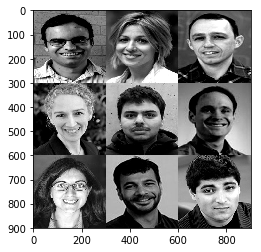

In [2]:
# number of images on the training set.
M = 14;
# read and show images(jpg);
# S will store all the images
S=[];
S, all_faces = utils.loadFaces('.\\instructors\\')
grid_im = utils.gray_images_square_grid(np.array(all_faces))
plt.imshow(grid_im, cmap='gray')

# Computing	Eigenfaces

In order to compute all Eigenfaces, we need to perform several processing steps. 

1. We first need to normalize the each image. Note that the normalized, square, gray images are saved in the same location as the script and will be reused several times. 

2. Compute a Mean (Average) face from all the normalized faces. 

3. Now, we can compute the Eigenfaces (Eigenvectors). The following code computes all the necessary components needed to compute the Eigenfaces and then finally saves (under the directory: “eigenfaces”) and shows the Eigenfaces:

In [3]:
def computeEigenFaces(S):
    dbx = np.array(S)
    A = dbx # Note that the dbx here is transposed as compared to the 
              # original M script
    
    # Covariance matrix C=A'A, L=AA'
    L = np.matmul(A, A.T)
    
    A=None
    
    dd, vv = np.linalg.eig(L) #Order here reversed from MATLAB
    # dd : eigenvalues
    # vv : eigenvectors
    # from the docs:
    # The normalized (unit “length”) eigenvectors, such that the column 
    # v[:,i] is the eigenvector corresponding to the eigenvalue w[i].
    
    # Sort and eliminate those whose eigenvalue is small
    
    nonzero_eigenvals = dd > 1e-4
    v = vv[:,nonzero_eigenvals]
    d = dd[nonzero_eigenvals]
    
    # Sort
    # eigenvalues already sorted, but in descending order, so let's
    # change this into ascending
    
    d = d[::-1]
    v = v[:,::-1]
    
    # Normalization also does not need to happen anymore, already done
    # by numpy
    
    # Now eigenvectors of the C matrix
    u = []
    for i in range(len(d)):
        temp = np.sqrt(d[i])
        u.append(np.matmul(dbx.T, v[:,i])/temp) 
    
    # Normalization of the C matrix
    for i in range(len(u)):
        kk = u[i]
        temp = np.sqrt(np.sum(np.square(kk)))
        u[i] = u[i]/temp
    
    return u

## Processing and Visualization

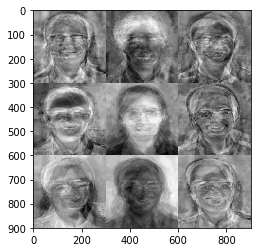

In [4]:
# Normalize
S = utils.normalizeImages(S)

# Compute average face
avg_face = utils.computeAverageFace(S)

EigenFaces = computeEigenFaces(S)

# Now render the eigenfaces
EigenFacesIm = []

for i in range(len(EigenFaces)):
    img = np.reshape(EigenFaces[i], (300,300))
    img = img.T
    # Scale the image
    img = utils.convertImageToU8bit(img)
    # convert and save
    im = Image.fromarray(img)
    im.convert('RGB').save('eigenfaces/eigen_{}.jpeg'.format(i+1))

    EigenFacesIm.append(img)

_, eigen_faces = utils.loadFaces('.\\eigenfaces\\')
grid_im = utils.gray_images_square_grid(np.array(eigen_faces))
plt.imshow(grid_im, cmap='gray')

# Reconstruct Image from EigenFaces

In order for us to reconstruct new (unseen) based on the eigenfaces computed earlier, we will need to first compute the weights of each eigenface in the training set. Then, we will compute the weights obtained for the new image. 

In [5]:
def reconstructNewFaces(u, mean_face, input_image = 'new_image.jpg'):
    # Find the weight of each face for each image in the training set.
    # omega will store this information for the training set.
    u = np.array(u)
        
    im = Image.open(input_image)
    InputImage = im.convert('L')
    
    im_raw = np.asarray(InputImage)
    InImage = np.reshape(im_raw.T,im_raw.shape[0]*im_raw.shape[1],1)
    temp = InImage
    me=np.mean(temp)
    st=np.std(temp)
    temp=(temp-me)*st/(st+me)
    Difference = temp-mean_face
    NormImage = temp
    
    p = np.matmul(u, NormImage.T)
        
    #m is the mean image, u is the eigenvector
    ReshapedImage = mean_face + np.matmul(p, u)
    ReshapedImage = np.reshape(ReshapedImage,im_raw.shape)
    ReshapedImage = ReshapedImage.T
    
    return ReshapedImage

## Show Reconstructed Image

In [6]:
ReshapedImage = reconstructNewFaces(EigenFaces, avg_face, 'new_image.jpg')

# Show the reconstructed image.
ReshapedImage_s = utils.convertImageToU8bit(ReshapedImage)
ReshapedImage_s = Image.fromarray(ReshapedImage_s)
ReshapedImage_s.show()